# Radial Velocity Tutorial for MCMC

By Roberto Tejada (2019)

This tutorial will assume the user is familiar with the `Driver` class and is acquainted with MCMC terminology. For more information about MCMC, see the [MCMC Introduction Tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/MCMC_tutorial.html). 

Here we explain how to fit radial velocity data using the MCMC technique. First we need a set of data containing radial velocity. We check the  data using `read_input` and observe the `quant_type` column for rv data. For more information on `orbitize.read_input.read_file()`, see the [Formatting Input Tutorial](https://orbitize.readthedocs.io/en/latest/formatting_inputs.html). 



## Import Modules and see rv data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import orbitize
from orbitize import read_input, system, priors, sampler, driver
import multiprocessing as mp
import pprint

testdata_path = '/home/sda/rtejada/orbitize/tests/' #your test data path here (change later to format)
data_table = read_input.read_file("{}/rv_testdata.csv".format(testdata_path)) #print all columns
data_table.pprint_all()

      epoch        object        quant1       quant1_err       quant2       quant2_err quant_type
------------------ ------ ------------------- ---------- ------------------ ---------- ----------
14.443893530264969      0  0.7328697175715004      0.005                nan        nan         rv
 2.349522089530793      0  0.2574797047881079      0.005                nan        nan         rv
 26.73791223014049      0  1.3032657995463084      0.005                nan        nan         rv
 82.75965774655013      0  3.5456328087800477      0.005                nan        nan         rv
54.753541906903706      0   2.890582625611117      0.005                nan        nan         rv
52.623542012868995      0  2.7671943059658552      0.005                nan        nan         rv
 44.86412910455361      0  2.3132278144563907      0.005                nan        nan         rv
 84.38683537917551      0   3.512404965408565      0.005                nan        nan         rv
  23.1396713831133  

The `quant_type` column displays the type of data each row contains: astrometry (radec) or radial velocity (rv). For astrometry, `quant1` column contains right ascension and the `quant2` column contains declination. For rv data, `quant1` contains radial velocity data, while `quant2` is filled with `NaN`. The table contains each respective error column. 

We can now initialize the `Driver` class. MCMC samplers take time to converge to absolute maxima in parameter space, and the more parameters we introduce, the longer we expect it to take.

## Create Driver Object

For orbit fits using RV data, it is always necessary to fit the primary and secondary masses (`m0` and `m1`respectively as separate free parameters. This differs from the astrometry-only case where fitting the total mass `mtot` suffices. We must therefore set the system keyword `fit_secondary_mass` to `True` when initializing the Driver object.

In [2]:
filename = "{}/rv_testdata.csv".format(testdata_path)

# system parameters
num_secondary_bodies = 1
system_mass = 1.97 # [Msol]
plx = 57.78 # [mas]
mass_err = 0.05 # [Msol]
plx_err = 0.05 # [mas]

# MCMC parameters
num_temps = 5
num_walkers = 30
num_threads = mp.cpu_count() # or a different number if you prefer


my_driver = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    system_kwargs = {'fit_secondary_mass':True,
                                  'tau_ref_epoch':0},
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads}
)

Since MCMC is class object in orbitize, we can assign a variable to the sampler and work with this variable like so:

In [3]:
m = my_driver.sampler

# RV Priors

The priors for the two radial velocity parameters, the radial velocity offset (gamma), and jitter (sigma), have default uniform prior and log uniform prior respectively. The gamma uniform prior is set between $(-5,5)$ km/s, and the jitter log uniform prior is set for ($10^{-4},0.05$) km/s. In `system.System`, we define the parameter `m1` as the companion mass and `m0` as the stellar mass. The prior for `m1` is a log uniform prior and is set for ($10^{-3},2.0$) The current version of orbitize addressed in this tutorial returns the stellar radial velocity only. 

We can change the priors as instructed in the [Modifying Priors](https://orbitize.readthedocs.io/en/latest/tutorials/Modifying_Priors.html) tutorial:

In [4]:
# getting the system object:

sys = my_driver.system

lab = sys.param_idx

print(sys.labels)
print(sys.sys_priors)

print(vars(sys.sys_priors[lab['m1']]))

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'gamma', 'sigma', 'm1', 'm0']
[Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, Gaussian, Uniform, Log Uniform, Log Uniform, Gaussian]
{'minval': 0.001, 'maxval': 2.0, 'logmin': -6.907755278982137, 'logmax': 0.6931471805599453}


In [5]:
# change the m1 prior:

sys.sys_priors[lab['m1']] = priors.LogUniformPrior(1e-4, 0.5)

print(sys.labels)
print(sys.sys_priors)
print(vars(sys.sys_priors[lab['m1']]))

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'gamma', 'sigma', 'm1', 'm0']
[Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, Gaussian, Uniform, Log Uniform, Log Uniform, Gaussian]
{'minval': 0.0001, 'maxval': 0.5, 'logmin': -9.210340371976182, 'logmax': -0.6931471805599453}


## Running the MCMC Sampler

As noted in the [MCMC Introduction Tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/MCMC_tutorial.html), we must choose the sampler step for MCMC and save every nth sample to avoid using too much disk space.

In [37]:
total_orbits = 10000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 10 # steps to burn in per walker
thin = 10 # only save every 10th step

In [7]:
m.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob =

/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


Burn in complete


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


330/334 steps completed
Run complete


Now we can plot the distribution of MCMC parameter of interest:

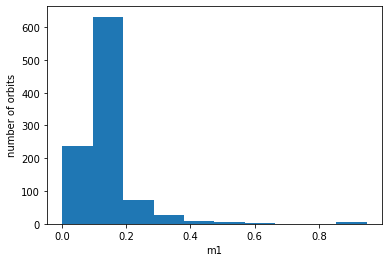

In [9]:
accepted_m1 = m.results.post[:, lab['m1']]
plt.hist(accepted_m1)
plt.xlabel('m1'); plt.ylabel('number of orbits')
plt.show()

# Saving Results over Extended MCMC Run

Sometimes our MCMC run will need to run for an extended period of time to let the walkers converge. To observe the convergence, we often need to see the walkers' progress along parameter space. We can save the sampler results periodically and keep running the sampler until convergence. Therefore, if we want to run for a greater number of steps and periodically save the results, we can create a for-loop and run for as many iterations as we'd like.  

We define a new driver object for this loop as follows:

In [35]:
# MCMC parameters
num_temps = 5
num_walkers = 30
num_threads = mp.cpu_count() # or a different number if you prefer

n_iter = 2 # number of iterations

my_driver = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    system_kwargs = {'fit_secondary_mass':True,
                                  'tau_ref_epoch':0},
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads}
)

m = my_driver.sampler

We defined the number iterations (`n_iter`), or the number of iterations the loop will run, and we defined `orbits_per_iter`, which defines the number of steps per iteration. We also want a place to save our results per each iteration, so we create a directory called `orbitize_results/mcmcrun`. The subfulder is a timestamp of the time we run our sampler formated as (year-month-day-hour-minute-second). Keeping track of the hours and seconds makes sure we do not create directories that already exist if we run the cell below more than once:

In [33]:
import os
from datetime import datetime

today = datetime.now()
path = '/home/sda/rtejada/' #update this path later 

directory = path + 'orbitize_results/mcmcrun/' + today.strftime('%Y-%m-%d-%H-%M-%S') + '/'
os.makedirs(directory)

We're now ready for the loop! The `results` object contains a `save_results` function which lets us save the results for our directory:

In [38]:
for i in range(n_iter):
    #running the sampler:
    orbits = m.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)
    results = m.results
    results.save_results(directory + 'orbits_rv_%1d' % i) #saves results object as an hdf5 file.

/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob =

/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


Burn in complete


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


330/334 steps completed
Run complete


/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sda/rtejada/orbitize/orbitize/priors.py:217: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log

Burn in complete


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/home/sda/rtejada/orbitize/orbitize/priors.py:326: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


330/334 steps completed
Run complete


# Plotting and Accesing Saved Results

We can plot the corner plot saved in the results object by following the steps in the [Advanced Plotting Tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/Plotting_tutorial.html):

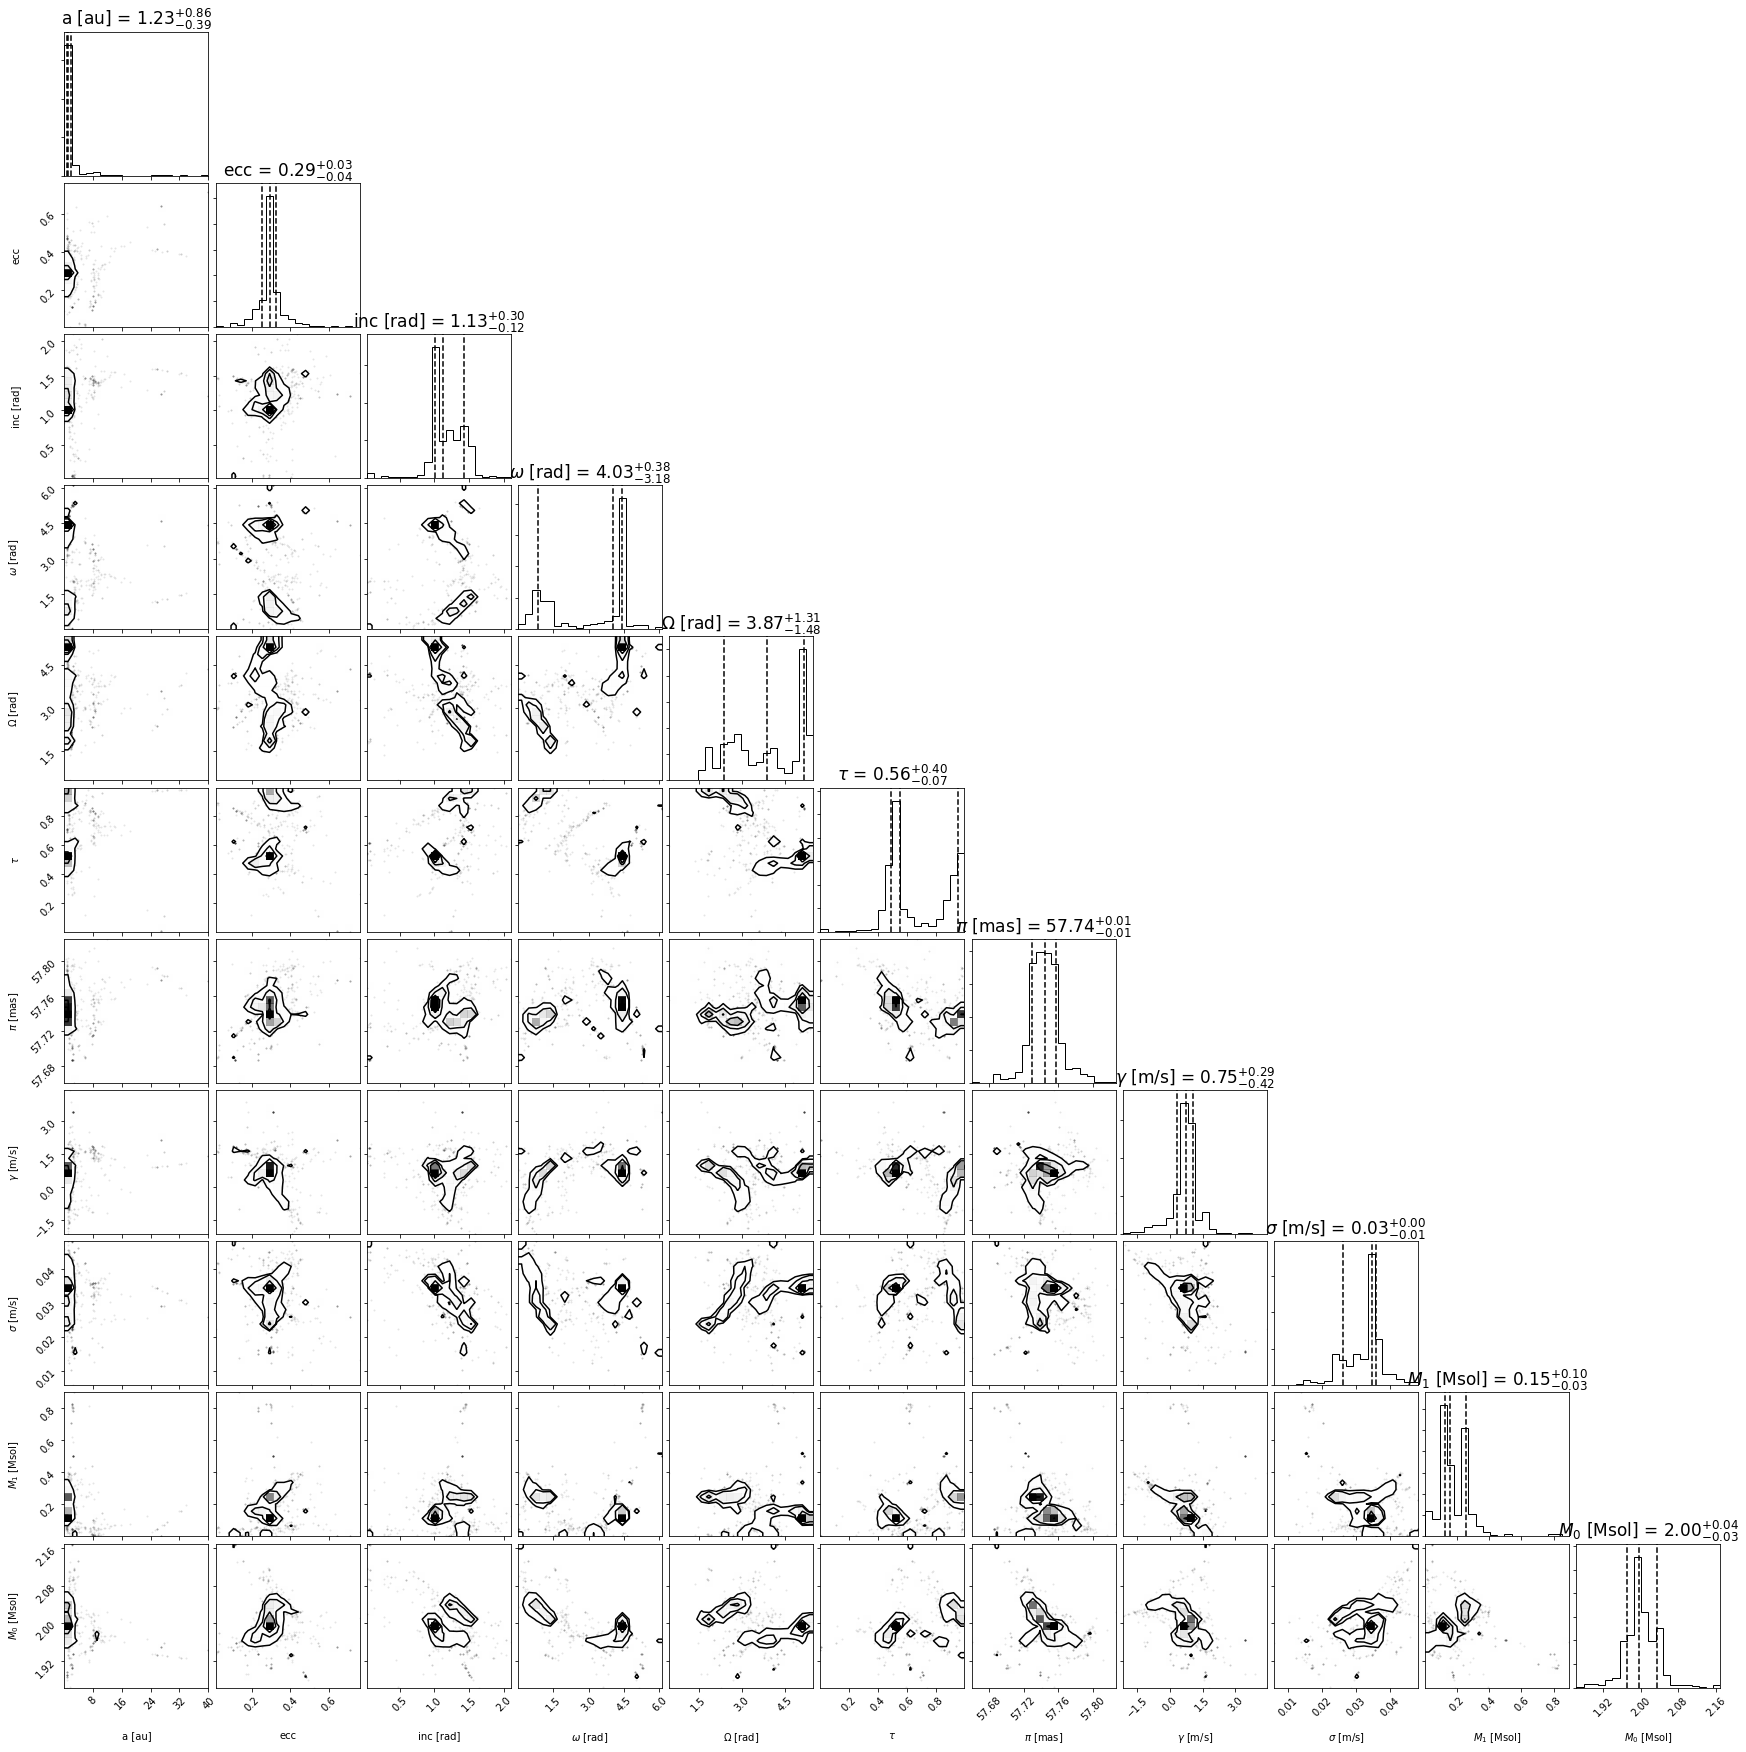

In [39]:
corner_figure = results.plot_corner(quantiles=[0.16,0.5,0.84],show_titles=True,title_kwargs={"fontsize": 17})

As illustrated in the plot above, MCMC needs more time to run. We only performed two iterations in the loop to demonstrate its useage, but with increased `n_iter`, the trendplots saved in the loop and the corner plot will show how the walkers converge to absolute extrema in parameter space.

To access the saved data, we can read it into a results object as shown in the [MCMC Introduction Tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/MCMC_tutorial.html):

In [40]:
from orbitize import results
hdf5_filename = directory + 'orbits_rv_1'
loaded_results = results.Results() # Create blank results object for loading
loaded_results.load_results(hdf5_filename)

To demonstrate use of the loaded results file above, we can use the saved results to plot our orbital plots:

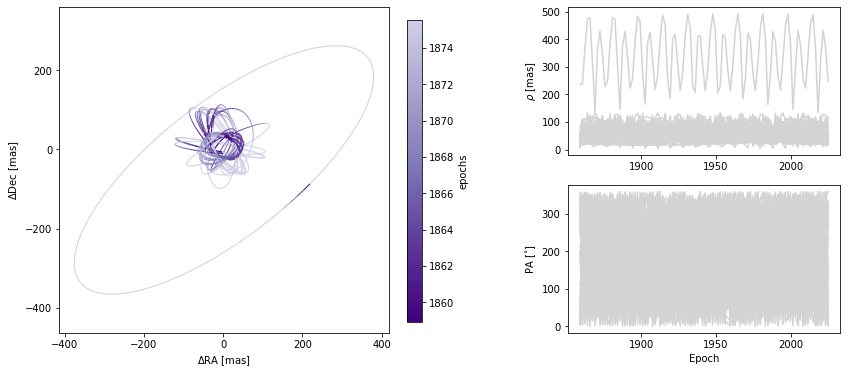

In [48]:
epochs = my_driver.system.data_table['epoch']
orbit_plot_fig = loaded_results.plot_orbits(
    object_to_plot = 1, # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot= 50, # Will plot 50 randomly selected orbits of this companion
    start_mjd=epochs[0] # Minimum MJD for colorbar (here we choose first data epoch)
)